In [1]:
import numpy as np
from skimage.io import imread, imshow, imsave
import os
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from skimage.morphology import binary_dilation, disk
from skimage.measure import regionprops, label

In [2]:
methods = ["Mesmer", "Stardist", "Cellpose", "UnMicst"]
datapath = "/home/groups/ChangLab/dataset/HMS-TMA-TNP/OHSU-TMA/Segmentations/"
sample_ids = ['Scene 002','Scene 003', 'Scene 017', 'Scene 049', 'Scene 059']

In [3]:
def dice_coeff(true, pred):
    true_f = true.flatten()
    pred_f = pred.flatten()
    union = np.sum(true_f) + np.sum(pred_f)
    if union==0:
        return 1
    intersection = np.sum(true_f * pred_f)
    return (2.* intersection/union)

In [6]:
from seg_utils import get_mask, get_gt

In [7]:
method_gt_table = np.zeros((len(methods), len(sample_ids)))
for m,method in enumerate(methods):
    for s,sid in enumerate(sample_ids):
        method_mask = get_mask(datapath, sid, method)
        method_mask = (method_mask > 0).astype('int')
        gt = get_gt(sid)
        gt = (gt > 0).astype('int')
        method_gt_table[m][s] = dice_coeff(gt, method_mask)
        

In [9]:
pd.DataFrame(method_gt_table, index=methods, columns=sample_ids)

,Scene 002,Scene 003,Scene 017,Scene 049,Scene 059
Mesmer,0.866914,0.833874,0.867354,0.845348,0.847514
Stardist,0.871493,0.798544,0.849238,0.836196,0.849104
Cellpose,0.852206,0.883965,0.844562,0.815968,0.839417
UnMicst,0.817395,0.810350,0.799904,0.738577,0.783098


# Evaluate methods using ground truth labels

In [14]:
dice_table = np.zeros((len(sample_ids), len(methods)))

for s,sid in enumerate(sample_ids):
    gt = get_gt(sid)
    gt = (gt > 0).astype('int')
    
    for m,method_out in enumerate(methods):
        methods_in = [m for m in methods if m != method_out]
        m_masks = []
        
        for method in methods_in:
            method_mask = get_mask(datapath, sid, method)
            method_mask[method_mask > 0] = 1
            m_masks.append(method_mask)
            
        pseudo_gt = (sum(m_masks) >= 3).astype('int')
        dice = dice_coeff(gt, pseudo_gt)
        dice_table[s,m] = dice

In [15]:
pd.DataFrame(dice_table, index=sample_ids, columns=[f'{m} dropped' for m in methods])

,Mesmer dropped,Stardist dropped,Cellpose dropped,UnMicst dropped
Scene 002,0.772368,0.777804,0.782760,0.807856
Scene 003,0.804119,0.821026,0.791103,0.838813
Scene 017,0.755549,0.769438,0.766917,0.798740
Scene 049,0.699210,0.706349,0.718214,0.780739
Scene 059,0.731426,0.737895,0.746556,0.787055


In [16]:
dice_delta_table = np.zeros((len(sample_ids), len(methods)))

for i,dice_i in enumerate(dice_table):
    mean_dice = np.mean(dice_i)

    for j,dice in enumerate(dice_i):
        dice_delta_table[i][j] = 100 * (dice - mean_dice) / mean_dice

In [17]:
pd.DataFrame(dice_delta_table, index=sample_ids, columns=[f'{m} dropped' for m in methods])

,Mesmer dropped,Stardist dropped,Cellpose dropped,UnMicst dropped
Scene 002,-1.633849,-0.941568,-0.310388,2.885805
Scene 003,-1.185376,0.892283,-2.784910,3.078004
Scene 017,-2.214663,-0.417136,-0.743405,3.375204
Scene 049,-3.707042,-2.723900,-1.089911,7.520853
Scene 059,-2.571761,-1.710083,-0.556368,4.838212


In [18]:
weights  = np.zeros(len(methods))
avg_deltas  = np.zeros(len(methods))
delta_table = dice_delta_table

for m, method in enumerate(methods):
    avg_deltas[m] = -np.mean(dice_delta_table[:,m])

weights = softmax(avg_deltas)

In [19]:
weights

array([0.62874652, 0.17438593, 0.19601406, 0.00085349])

In [20]:
def get_dice_scores(sample_ids, methods, weights):
    dices = np.zeros(len(sample_ids))

    for s,sid in enumerate(sample_ids):
        gt = get_gt(sid)
        gt = (gt > 0).astype('int')
        m_masks = []

        for m,method in enumerate(methods):
            method_mask = get_mask(datapath, sid, method).astype('float')
            method_mask[method_mask > 0] = weights[m]
            m_masks.append(method_mask)

        pseudo_gt = (sum(m_masks) >= 0.75).astype('int')
        dices[s] = dice_coeff(gt, pseudo_gt)
        
    return dices

In [21]:
equal_weights = np.ones(len(methods)) * (1/len(methods))
dices = get_dice_scores(sample_ids, methods, equal_weights)
w_dices = get_dice_scores(sample_ids, methods, weights)

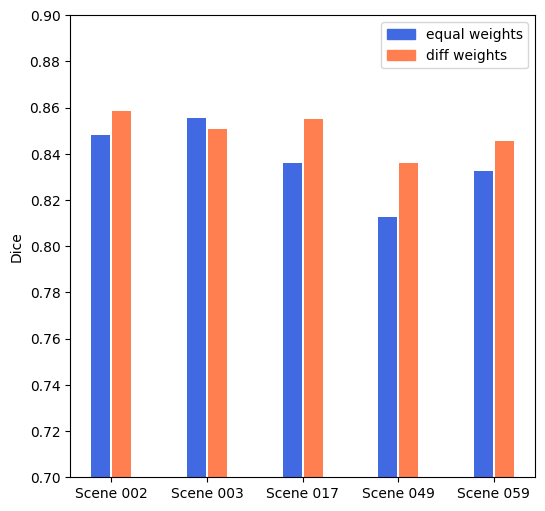

In [22]:
xlabels = [s.split('-')[-1].strip() for s in sample_ids]
fig, ax = plt.subplots(1, figsize=(6,6))

ax.set(ylim=[0.70,0.9])

ax.bar(np.arange(5)-0.11, dices, color='royalblue', width=0.2)
ax.bar(np.arange(5)+0.11, w_dices, color='coral', width=0.2)

plt.setp(ax, xticks=np.arange(5), xticklabels=xlabels)

labels = ['equal weights', 'diff weights']
handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['royalblue','coral']]

plt.yticks(np.arange(0.7, 0.9, 0.02))
plt.legend(handles, labels)
plt.ylabel('Dice')
plt.show()